# Домашнее задание 3

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 февраля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_3

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Вновь рассмотрим задачу минимизации эмпирического риска:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n l (g(w, x_i), y_i).
\end{equation}

В прошлом задании работа шла с линейной модель $g(w, x) = w^T x$ и квадратичную функцию потерь $l(z, y) = (z-y)^2$. 

__(а)__ В дополнение к квадратичной функции потерь реализуйте логистическую/сигмоидную: $l(z,y) = \ln (1 + \exp(-yz))$ (__Важно: $y$ должен принимать значения $-1$ или $1$__). Выпишите градиент. Является ли новая задача регресии выпуклой? Оцените $L$ для новой функции потерь. 

$\frac{1}{n}\sum\limits_{i = 1}^{n} l(\omega^Т x_i, y_i)=  \frac{1}{n} \sum\limits_{i = 1}^{n}\ln(1 + \exp(-\omega^Tx_iy_i))=  f(\omega)$
#### Вычислим $\nabla f(\omega). df(\omega) = -\frac{1}{n}\sum\limits_{i = 1}^{n}\frac{\exp(-\omega^Tx_iy_i)}{1 + \exp(-\omega^Tx_iy_i)}x_iy_i d\omega\Rightarrow \nabla f(\omega) = -\frac{1}{n}\sum\limits_{i = 1}^{n}\frac{\exp(-\omega^Tx_iy_i)}{1 + \exp(-\omega^Tx_iy_i)}x_iy_i$
#### Вычислим $\nabla^2 f(\omega). d^2f(\omega) = \frac{1}{n}\sum\limits_{i = 1}^n \frac{\exp(-\omega^Tx_iy_i)}{(1 + \exp(-\omega^Tx_iy_i))^2}x_ix_i^T(y_i)^2 d\omega\Rightarrow \nabla^2 f(\omega) =  \frac{1}{n}\sum\limits_{i = 1}^n \frac{\exp(-\omega^Tx_iy_i)}{(1 + \exp(-\omega^Tx_iy_i))^2}x_ix_i^T(y_i)^2$.
#### Ввиду того, что $x_ix_i^T$ всегда положительно полуопределенаб а остальные множители положителные, то $\nabla^2 f(\omega)$ положительно полуопределена, а значит задача выпуклая.
#### Оценим $L$. Представим гессиан в виде: $\nabla^2 f(\omega) = \frac{1}{n}\sum\limits_{i = 1}^n \frac{1}{(1 + \exp(-\omega^Tx_iy_i))(\frac{1}{\exp(-\omega^Tx_iy_i)} + 1)}x_ix_i^T$. Знаменатель приминает минимальное значение 2, а значит все выражение оценивается сверху, как $\nabla^2 f(\omega) \leq \frac{1}{2n}\sum\limits_{i = 1}^n x_ix_i^T$. Тогда $L$ можно оценить, как самое большое собственное значение $\frac{1}{2n}\sum\limits_{i = 1}^n x_ix_i^T$.

__(б)__ Возьмите датасет _mushrooms_ из прошлого задания. Проделайте следующие шаги из прошлого задания, только с логистической функцией потерь:

1) Разделите данные на две части: обучающую и тестовую.

2) Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$ задачи обучения/оптимизации.

3) Используя градиентный спуск, обучите новую модель (без ограничений и регуляризаций). Постройте график: точность от номера итерации.

4) Если в пункте 3) пришлось столкнуться с проблемами или просто необходимо улучшить точность, то добавьте ограничения или $\ell_2$-регуляризацию, как в прошлом ДЗ.

5) Сравните с результатами квадратичной функции потерь из прошлого ДЗ.

In [51]:
import numpy as np
from numpy import linalg
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
import math
import pandas as pd
from datetime import datetime
from scipy.spatial import distance
import re
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import ortho_group
m = ortho_group.rvs(dim=3)
from sklearn import ensemble, model_selection, metrics, tree
%matplotlib inline
from sklearn.datasets import load_digits
import time

#### Разделим датасет на две части, заменив в векторе $y$ 2 на -1.

In [2]:
dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape

for i in range (n):
    if (y[i] == 2):
        y[i] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
n_train, d_train = X_train.shape
n_test, d_test = X_test.shape

In [3]:
L = 1/(2*n_train)*max(np.linalg.eigvals(X_train.dot(X_train.T)))
print("L = ", L)

L =  (5.16927772574459+0j)


#### Решим задачу методом градиентоного спуска

In [4]:
def func(X, y, omega):
    S = 0
    for i in range (n_train):
        expon = np.exp(-omega.T.dot(X[i])*(y[i]))
        S = S + np.log(1 + expon)
    return 1/n_train*S
def gradient(X, y, omega):
    S = 0
    for i in range (n_train):
        expon = np.exp(-omega.T.dot(X[i])*(y[i]))
        S = S + expon/(1 + expon)*X[i]*y[i]
    return -1/n_train*S

def gradient_descent(X, y, start, learning_rate, amount_of_iterations):
    omega = start
    omega = omega.reshape(1, d_train)
    begin_time = time.time()
    timeprog = []
    grad_array = np.zeros(d_train)
    grad_array.reshape(1, d_train)
    for i in range (1, amount_of_iterations):
        grad = gradient(X, y, omega[i-1])
        grad_array = np.vstack([grad_array, grad])
        omega = np.vstack([omega, omega[i-1] - learning_rate*grad])
        if (i % 100 == 0):
            timeprog.append(time.time() - begin_time)
    return omega, grad_array, timeprog
res1, grad1, time1 = gradient_descent(X_train, y_train, np.ones(d_train), 1/L, 2000)

In [5]:
print("Критерий через близость градиента к нулю", gradient(X_train, y_train, res1[1999]).dot(gradient(X_train, y_train, res1[1999])))

def precisions(iteration, res):
    number_of_true_precisions = 0
    for i in range (n_test): 
        if (res[iteration].dot(X_test[i]) > 0):
            k = 1
        else:
            k = -1
        if (k == int(y_test[i])):
            number_of_true_precisions = number_of_true_precisions + 1   
    procent_of_precisions = number_of_true_precisions/y_test.shape[0]
    return procent_of_precisions

print("точность", precisions(1999, res1))

Критерий через близость градиента к нулю (4.265349958516235e-05+0j)
точность 0.9993846153846154


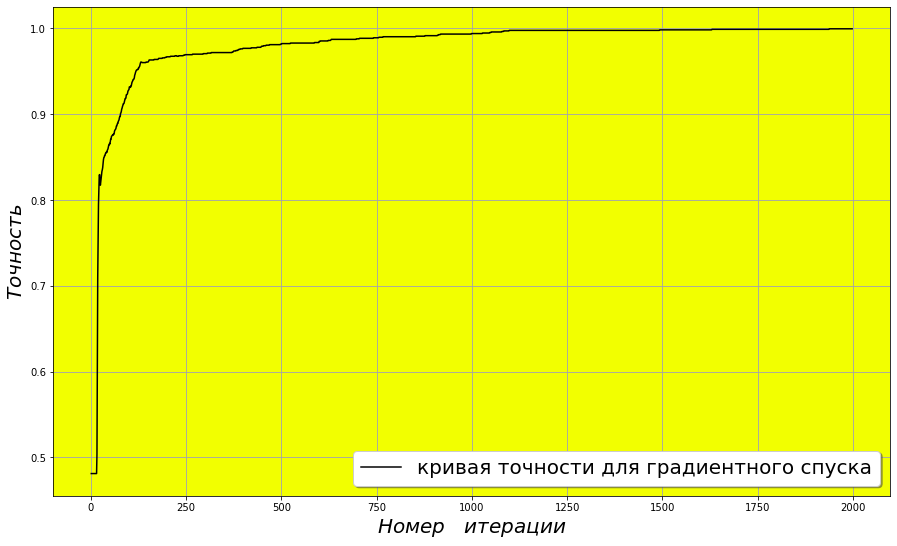

In [6]:
Xg = np.array([])
for i in range (1, 1999):
    Xg = np.append(Xg, i)
Yg = np.array([])
for i in range (1, 1999):
    Yg = np.append(Yg, precisions(i, res1))
    
    
fig, ax1 = plt.subplots(figsize = (15, 9))

ax1.grid(color = (0.65, 0.65, 0.65), linewidth = 0.9)
ax1.set_facecolor((0.95, 1, 0))


ax1.errorbar(Xg, Yg, fmt = '-',
            color = 'k', ms = 4, label = 'кривая точности для градиентного спуска')


ax1.set_xlabel('$Номер\quad итерации$', fontsize = '20')
ax1.set_ylabel('$Точность$', fontsize = '20')

plt.rc('font', size=16) 

leg = ax1.legend(fontsize = '20', shadow = True)

#### В регуляризации нет необходимости, точность такая же высокая, как и в задаче с квадратичной функцией потерь после ее регуляризации. Модель ошибается всего 1 раз.

## Задача 2

__(a)__ Реализуйте метод тяжелого шарика. 

In [7]:
def heavy_ball(X, y, start, learning_rate, inertion ,amount_of_iterations):
    omega = start
    omega = omega.reshape(1, d_train)
    begin_time = time.time()
    timeprog = []
    grad_array = np.zeros(d_train)
    grad_array.reshape(1, d_train)
    for i in range (1, amount_of_iterations):
        grad = gradient(X, y, omega[i-1])
        grad_array = np.vstack([grad_array, grad])
        omega = np.vstack([omega, omega[i-1] - learning_rate*grad + inertion*(omega[i-1] - omega[i-2])])
        if (i % 100 == 0):
            timeprog.append(time.time() - begin_time)
    return omega, grad_array, timeprog

__(б)__ Решите задачу логистической регрессии с помощью метода тяжелого шарика (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

#### Решим задачу методом тяжелого шарика со значением моментума 0.99

In [8]:
res3, grad3, time3 = heavy_ball(X_train, y_train, np.ones(d_train), 1/L, 0.99 ,10000)
print("точность", precisions(9999, res3))
print("Критерий через близость градиента к нулю", grad3[9999].dot(grad3[9999]))

точность 1.0
Критерий через близость градиента к нулю (3.09056491958034e-11+0j)


#### Построим график точности от времени

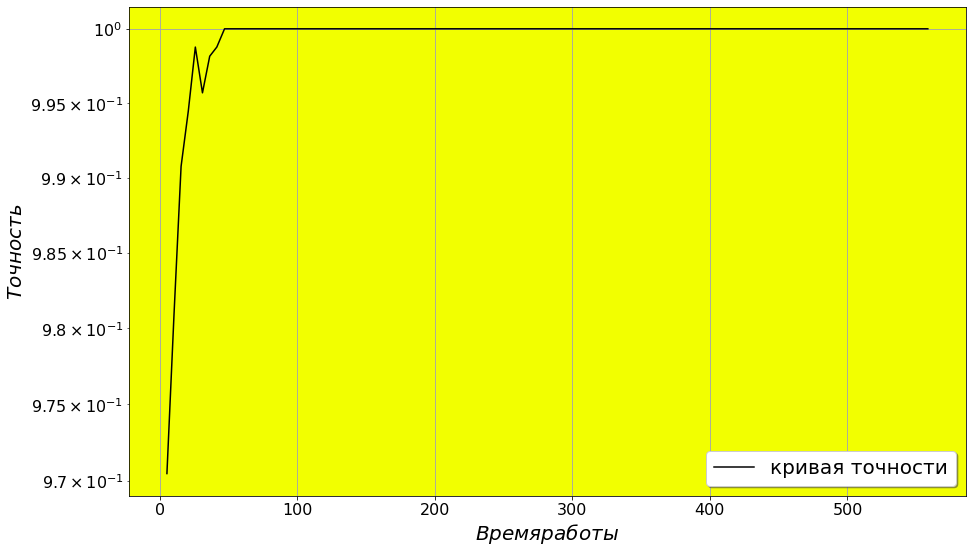

In [9]:
Xh = np.array([])
for i in range (0, 99):
    Xh = np.append(Xh, time3[i])
Yh = np.array([])
for i in range (1, 100):
    Yh = np.append(Yh, precisions(100*i, res3))
    
    
fig, ax1 = plt.subplots(figsize = (15, 9))

ax1.grid(color = (0.65, 0.65, 0.65), linewidth = 0.9)
ax1.set_facecolor((0.95, 1, 0))


ax1.errorbar(Xh, Yh, fmt = '-',
            color = 'k', ms = 4, label = 'кривая точности')

ax1.semilogy()

ax1.set_xlabel('$Время работы$', fontsize = '20')
ax1.set_ylabel('$Точность$', fontsize = '20')

plt.rc('font', size=16) 

leg = ax1.legend(fontsize = '20', shadow = True)

#### Видим, что 100% точность достигается гораздо раньше времени окончания работы программы. В таком случае, без ограничения общности, сократим количество итераций в 5 раз, чтобы уменьшить время работы программы. Если найдется какой-то моментум, на котором точность достигается быстрее, то мы это все равно увидим.

In [10]:
res3, grad3, time3 = heavy_ball(X_train, y_train, np.ones(d_train), 1/L, 0.99, 2000)
print('*')
res4, grad4, time4 = heavy_ball(X_train, y_train, np.ones(d_train), 1/L, 0.66, 2000)
print('*')
res5, grad5, time5 = heavy_ball(X_train, y_train, np.ones(d_train), 1/L, 0.33, 2000)
print('*')
res6, grad6, time6 = heavy_ball(X_train, y_train, np.ones(d_train), 1/L, -0.33, 2000)
print('*')
res7, grad7, time7 = heavy_ball(X_train, y_train, np.ones(d_train), 1/L, -0.66, 2000)
print('*')
res8, grad8, time8 = heavy_ball(X_train, y_train, np.ones(d_train), 1/L, -0.99, 2000)

*
*
*
*
*


C:\Users\Daniil\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


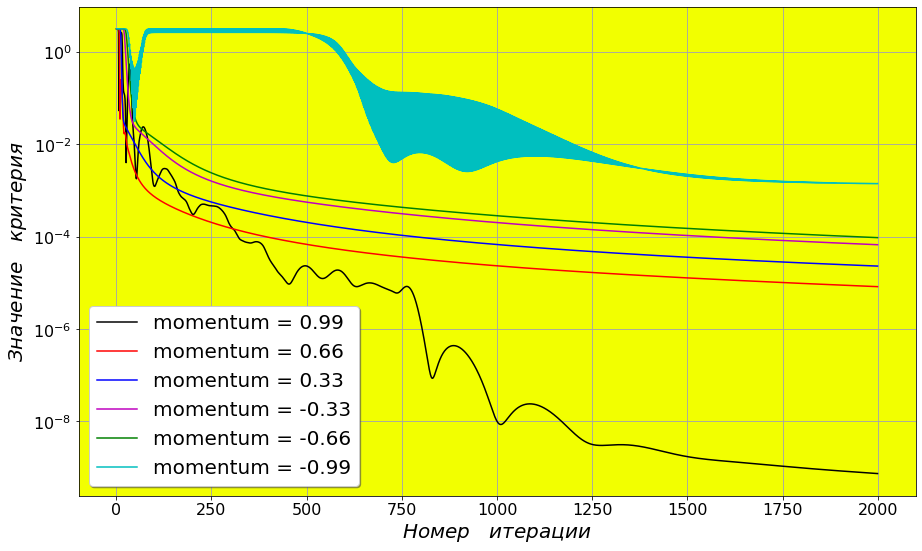

In [11]:
X = np.array([])
for i in range (1, 2000):
    X = np.append(X, i)
Y1 = np.array([])
for i in range (1, 2000):
    Y1 = np.append(Y1, grad3[i].dot(grad3[i]))
Y2 = np.array([])
for i in range (1, 2000):
    Y2 = np.append(Y2, grad4[i].dot(grad4[i]))
Y3 = np.array([])
for i in range (1, 2000):
    Y3 = np.append(Y3, grad5[i].dot(grad5[i]))
Y4 = np.array([])
for i in range (1, 2000):
    Y4 = np.append(Y4, grad6[i].dot(grad6[i]))
Y5 = np.array([])
for i in range (1, 2000):
    Y5 = np.append(Y5, grad7[i].dot(grad7[i]))
Y6 = np.array([])
for i in range (1, 2000):
    Y6 = np.append(Y6, grad8[i].dot(grad8[i]))

    
fig, ax1 = plt.subplots(figsize = (15, 9))

ax1.grid(color = (0.65, 0.65, 0.65), linewidth = 0.9)
ax1.set_facecolor((0.95, 1, 0))


ax1.errorbar(X, Y1, fmt = '-',
            color = 'k', ms = 4, label = 'momentum = 0.99')
ax1.errorbar(X, Y2, fmt = '-',
            color = 'r', ms = 4, label = 'momentum = 0.66')
ax1.errorbar(X, Y3, fmt = '-',
            color = 'b', ms = 4, label = 'momentum = 0.33')
ax1.errorbar(X, Y4, fmt = '-',
            color = 'm', ms = 4, label = 'momentum = -0.33')
ax1.errorbar(X, Y5, fmt = '-',
            color = 'g', ms = 4, label = 'momentum = -0.66')
ax1.errorbar(X, Y6, fmt = '-',
            color = 'c', ms = 4, label = 'momentum = -0.99')

ax1.semilogy()

ax1.set_xlabel('$Номер\quad итерации$', fontsize = '20')
ax1.set_ylabel('$Значение\quad критерия$', fontsize = '20')

plt.rc('font', size=16) 

leg = ax1.legend(fontsize = '20', shadow = True)

__(в)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте на этот же график сходимость градиентного спуска с шагом $\frac{1}{L}$. Сделайте вывод.

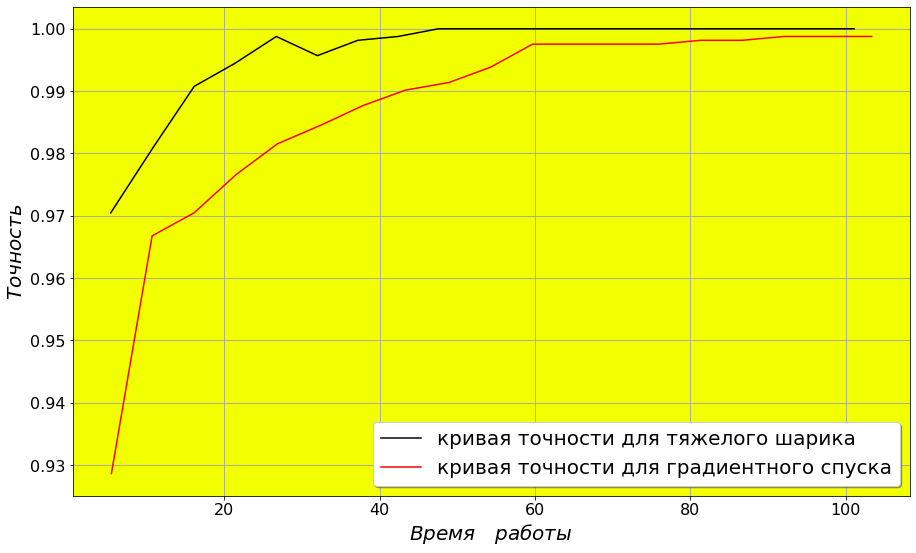

In [12]:
Xh = np.array([])
for i in range (0, 19):
    Xh = np.append(Xh, time3[i])
Yh = np.array([])
for i in range (1, 20):
    Yh = np.append(Yh, precisions(100*i, res3))
Xg = np.array([])
for i in range (0, 19):
    Xg = np.append(Xg, time1[i])
Yg = np.array([])
for i in range (1, 20):
    Yg = np.append(Yg, precisions(100*i, res1))
    
    
fig, ax1 = plt.subplots(figsize = (15, 9))

ax1.grid(color = (0.65, 0.65, 0.65), linewidth = 0.9)
ax1.set_facecolor((0.95, 1, 0))


ax1.errorbar(Xh, Yh, fmt = '-',
            color = 'k', ms = 4, label = 'кривая точности для тяжелого шарика')
ax1.errorbar(Xg, Yg, fmt = '-',
            color = 'r', ms = 4, label = 'кривая точности для градиентного спуска')


ax1.set_xlabel('$Время\quad работы$', fontsize = '20')
ax1.set_ylabel('$Точность$', fontsize = '20')

plt.rc('font', size=16) 

leg = ax1.legend(fontsize = '20', shadow = True)

#### Из графиков видим, что метод тяжелого шарика дает более высокую точность за меньшее время.

__(г)__ Если в пунктах (б) и (в) столкнулись с проблемами, попробуйте $\ell_2$-регуляризовать задачу или рассмотреть ее на ограниченном множестве.

#### Мы получили 100% точность, в регуляризации нет необходимости.

__(д)__ Реализуйте ускоренный метод Нестерова (в форме Нестерова, а не который доказывали на семинаре). 

In [52]:
def nesterov_acceleration(X, y, start, learning_rate, inertion ,amount_of_iterations):
    omega = start
    omega = omega.reshape(1, d_train)
    begin_time = time.time()
    timeprog = []
    grad_array = np.zeros(d_train)
    grad_array.reshape(1, d_train)
    for i in range (1, amount_of_iterations):
        grad = gradient(X, y, omega[i-1] + inertion*(omega[i-1] - omega[i-2]))
        grad_array = np.vstack([grad_array, grad])
        omega = np.vstack([omega, omega[i-1] - learning_rate*grad + inertion*(omega[i-1] - omega[i-2])])
        if (i % 100 == 0):
            timeprog.append(time.time() - begin_time)
    return omega, grad_array, timeprog

__(е)__ Решите задачу логистической регресии с помощью метода Нестерова (не забудьте разделить выборку на две части: обучающую и тестовую). Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Проверьте также значения моментума равные $\frac{k}{k+3}$, $\frac{k}{k+2}$, $\frac{k}{k+1}$ ($k$ - номер итерации), а если решаете сильно выпуклую задачу, то и $\frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно) для различных значений моментума. Всегда ли сходимость является монотонной?

#### Решим задачу методом Нестерова со значением моментума 0.99

In [14]:
res_n1, grad_n1, time_n1 = nesterov_acceleration(X_train, y_train, np.ones(d_train), 1/L, 0.99, 10000)
print("точность", precisions(9999, res_n1))
print("Критерий через близость градиента к нулю", grad_n1[9999].dot(grad_n1[9999]))

точность 1.0
Критерий через близость градиента к нулю (4.0046916300116335e-11+0j)


#### Построим график точности от времени

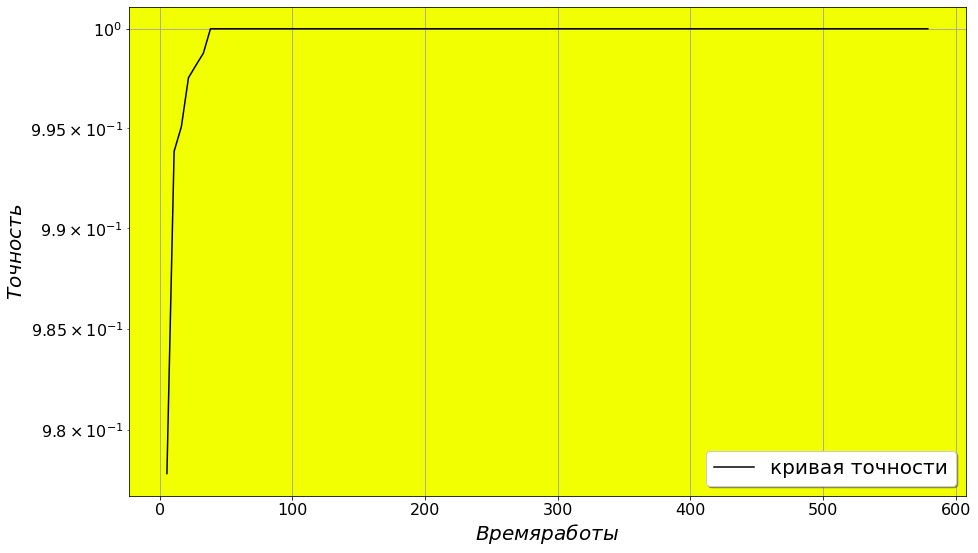

In [16]:
X = np.array([])
for i in range (0, 99):
    X = np.append(X, time_n1[i])
Y = np.array([])
for i in range (1, 100):
    Y = np.append(Y, precisions(100*i, res_n1))
    
fig, ax1 = plt.subplots(figsize = (15, 9))

ax1.grid(color = (0.65, 0.65, 0.65), linewidth = 0.9)
ax1.set_facecolor((0.95, 1, 0))


ax1.errorbar(X, Y, fmt = '-',
            color = 'k', ms = 4, label = 'кривая точности')

ax1.semilogy()

ax1.set_xlabel('$Время работы$', fontsize = '20')
ax1.set_ylabel('$Точность$', fontsize = '20')

plt.rc('font', size=16) 

leg = ax1.legend(fontsize = '20', shadow = True)

#### Видим, что 100% точность достигается гораздо раньше времени окончания работы программы. В таком случае, без ограничения общности, сократим количество итераций в 5 раз, чтобы уменьшить время работы программы. Если найдется какой-то моментум, на котором точность достигается быстрее, то мы это все равно увидим.

In [53]:
res_n1, grad_n1, time_n1 = nesterov_acceleration(X_train, y_train, np.ones(d_train), 1/L, 0.99, 2000)
print('*')
res_n2, grad_n2, time_n2 = nesterov_acceleration(X_train, y_train, np.ones(d_train), 1/L, 0.5, 2000)
print('*')
res_n3, grad_n3, time_n3 = nesterov_acceleration(X_train, y_train, np.ones(d_train), 1/L, -0.5, 2000)
print('*')
res_n4, grad_n4, time_n4 = nesterov_acceleration(X_train, y_train, np.ones(d_train), 1/L, -0.99, 2000)
print('*')
res_n5, grad_n5, time_n5 = nesterov_acceleration(X_train, y_train, np.ones(d_train), 1/L, i/(i+1), 2000)
print('*')
res_n6, grad_n6, time_n6 = nesterov_acceleration(X_train, y_train, np.ones(d_train), 1/L, i/(i+2), 2000)
print('*')
res_n7, grad_n7, time_n7 = nesterov_acceleration(X_train, y_train, np.ones(d_train), 1/L, i/(i+3), 2000)

*
*
*
*
*
*


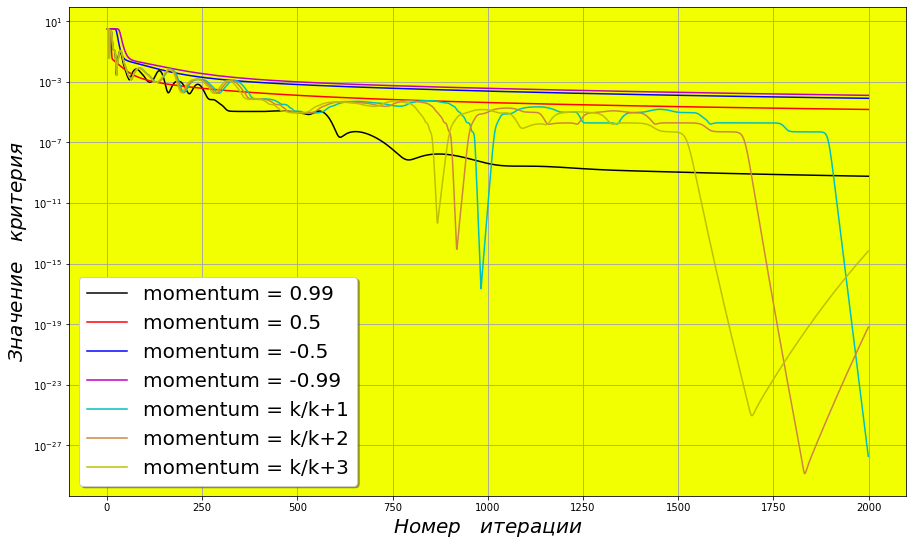

In [54]:
X = np.array([])
for i in range (1, 2000):
    X = np.append(X, i)
Y1 = np.array([])
for i in range (1, 2000):
    Y1 = np.append(Y1, grad_n1[i].dot(grad_n1[i]))
Y2 = np.array([])
for i in range (1, 2000):
    Y2 = np.append(Y2, grad_n2[i].dot(grad_n2[i]))
Y3 = np.array([])
for i in range (1, 2000):
    Y3 = np.append(Y3, grad_n3[i].dot(grad_n3[i]))
Y4 = np.array([])
for i in range (1, 2000):
    Y4 = np.append(Y4, grad_n4[i].dot(grad_n4[i]))
Y5 = np.array([])
for i in range (1, 2000):
    Y5 = np.append(Y5, grad_n5[i].dot(grad_n5[i]))
Y6 = np.array([])
for i in range (1, 2000):
    Y6 = np.append(Y6, grad_n6[i].dot(grad_n6[i]))
Y7 = np.array([])
for i in range (1, 2000):
    Y7 = np.append(Y7, grad_n7[i].dot(grad_n7[i]))

    
fig, ax1 = plt.subplots(figsize = (15, 9))

ax1.grid(color = (0.65, 0.65, 0.65), linewidth = 0.9)
ax1.set_facecolor((0.95, 1, 0))


ax1.errorbar(X, Y1, fmt = '-',
            color = 'k', ms = 4, label = 'momentum = 0.99')
ax1.errorbar(X, Y2, fmt = '-',
            color = 'r', ms = 4, label = 'momentum = 0.5')
ax1.errorbar(X, Y3, fmt = '-',
            color = 'b', ms = 4, label = 'momentum = -0.5')
ax1.errorbar(X, Y4, fmt = '-',
            color = 'm', ms = 4, label = 'momentum = -0.99')
ax1.errorbar(X, Y5, fmt = '-',
            color = 'c', ms = 4, label = 'momentum = k/k+1')
ax1.errorbar(X, Y6, fmt = '-',
            color = "peru", ms = 4, label = 'momentum = k/k+2')
ax1.errorbar(X, Y7, fmt = '-',
            color = 'y', ms = 4, label = 'momentum = k/k+3')

ax1.semilogy()

ax1.set_xlabel('$Номер\quad итерации$', fontsize = '20')
ax1.set_ylabel('$Значение\quad критерия$', fontsize = '20')

plt.rc('font', size=16) 

leg = ax1.legend(fontsize = '20', shadow = True)

__(ж)__ Для лучшего значения моментума постройте график зависимости точности модели на тестовой выборке от времени работы метода. Добавьте этот график к графикам для тяжелого шарика и градиентного спуска из пункта (г). Сделайте итоговый вывод.

#### Построим графики точности для моментумов $0.99,\frac{k}{k+1} \frac{k}{k+2}, \frac{k}{k + 3}$

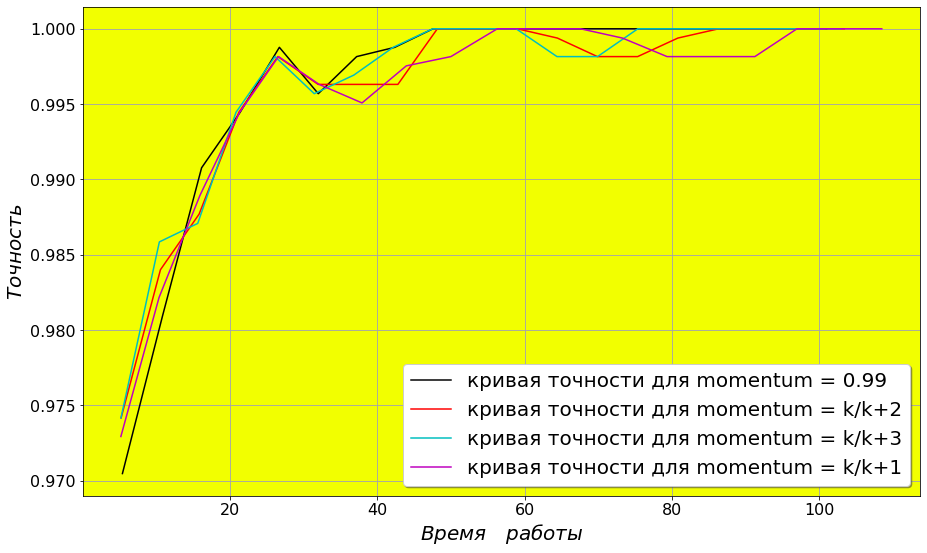

In [55]:
X1 = np.array([])
for i in range (0, 19):
    X1 = np.append(Xh, time_n1[i])
Y1 = np.array([])
for i in range (1, 20):
    Y1 = np.append(Yh, precisions(100*i, res_n1))
X2 = np.array([])
for i in range (0, 19):
    X2 = np.append(X2, time_n6[i])
Y2 = np.array([])
for i in range (1, 20):
    Y2 = np.append(Y2, precisions(100*i, res_n6))
X3 = np.array([])
for i in range (0, 19):
    X3 = np.append(X3, time_n7[i])
Y3 = np.array([])
for i in range (1, 20):
    Y3 = np.append(Y3, precisions(100*i, res_n7))
X4 = np.array([])
for i in range (0, 19):
    X4 = np.append(X4, time_n5[i])
Y4 = np.array([])
for i in range (1, 20):
    Y4 = np.append(Y4, precisions(100*i, res_n5))
    
    
fig, ax1 = plt.subplots(figsize = (15, 9))

ax1.grid(color = (0.65, 0.65, 0.65), linewidth = 0.9)
ax1.set_facecolor((0.95, 1, 0))


ax1.errorbar(X1, Y1, fmt = '-',
            color = 'k', ms = 4, label = 'кривая точности для momentum = 0.99')
ax1.errorbar(X2, Y2, fmt = '-',
            color = 'r', ms = 4, label = 'кривая точности для momentum = k/k+2')
ax1.errorbar(X3, Y3, fmt = '-',
            color = 'c', ms = 4, label = 'кривая точности для momentum = k/k+3')
ax1.errorbar(X4, Y4, fmt = '-',
            color = 'm', ms = 4, label = 'кривая точности для momentum = k/k+1')


ax1.set_xlabel('$Время\quad работы$', fontsize = '20')
ax1.set_ylabel('$Точность$', fontsize = '20')

plt.rc('font', size=16) 

leg = ax1.legend(fontsize = '20', shadow = True)

#### Среди этих моментумов найдем тот, на котором точность 100% достигается быстрее всего

In [56]:
def minim_time():
    minim5 = 0
    for i in range (2000):
        if (precisions(i, res_n5) == int(1)):
            minim5 = i
            break
    minim6 = 0
    for i in range (2000):
        if (precisions(i, res_n6) == int(1)):
            minim6 = i
            break
    minim7 = 0
    for i in range (2000):
        if (precisions(i, res_n7) == int(1)):
            minim7 = i
            break
    minim1 = 0
    for i in range (2000):
        if (precisions(i, res_n1) == int(1)):
            minim1 = i
            break
    if (min(minim1, minim5, minim6, minim7) == minim1):
        return res_n1, time_n1
    if (min(minim1, minim5, minim6, minim7) == minim5):
        return res_n5, time_n5
    if (min(minim1, minim5, minim6, minim7) == minim6):
        return res_n6, time_n6
    if (min(minim1, minim5, minim6, minim7) == minim7):
        return res_n7, time_n7

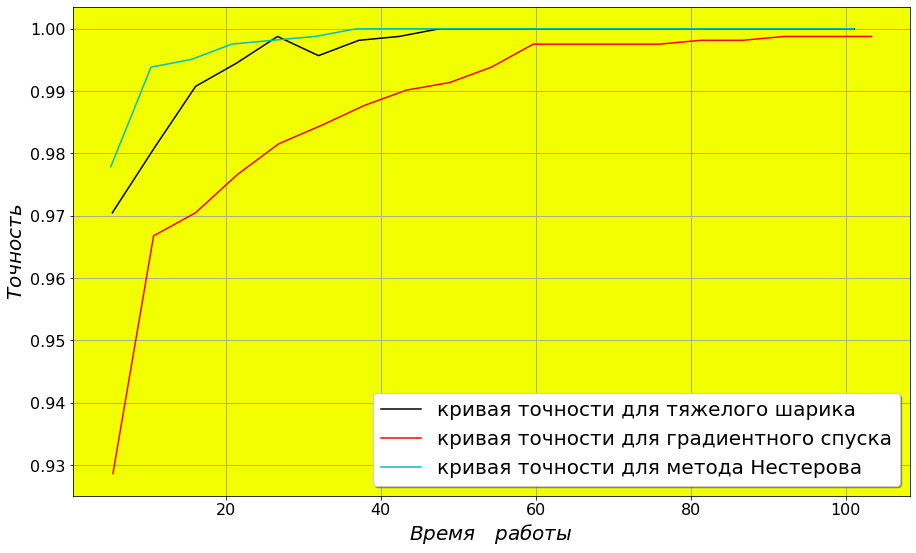

In [57]:
Xh = np.array([])
for i in range (0, 19):
    Xh = np.append(Xh, time3[i])
Yh = np.array([])
for i in range (1, 20):
    Yh = np.append(Yh, precisions(100*i, res3))
Xg = np.array([])
for i in range (0, 19):
    Xg = np.append(Xg, time1[i])
Yg = np.array([])
for i in range (1, 20):
    Yg = np.append(Yg, precisions(100*i, res1))
res = minim_time()[0]
time = minim_time()[1]
Xn = np.array([])
for i in range (0, 19):
    Xn = np.append(Xn, time[i])
Yn = np.array([])
for i in range (1, 20):
    Yn = np.append(Yn, precisions(100*i, res))
    
    
fig, ax1 = plt.subplots(figsize = (15, 9))

ax1.grid(color = (0.65, 0.65, 0.65), linewidth = 0.9)
ax1.set_facecolor((0.95, 1, 0))


ax1.errorbar(Xh, Yh, fmt = '-',
            color = 'k', ms = 4, label = 'кривая точности для тяжелого шарика')
ax1.errorbar(Xg, Yg, fmt = '-',
            color = 'r', ms = 4, label = 'кривая точности для градиентного спуска')
ax1.errorbar(Xn, Yn, fmt = '-',
            color = 'c', ms = 4, label = 'кривая точности для метода Нестерова')


ax1.set_xlabel('$Время\quad работы$', fontsize = '20')
ax1.set_ylabel('$Точность$', fontsize = '20')

plt.rc('font', size=16) 

leg = ax1.legend(fontsize = '20', shadow = True)

#### Видим, что быстрее всего модель достигает максимальной точности, при обучении с помощью метода Нестерова.

__Бонусные пункт__

__(з)__ Сделаем подбор константы $L$ адаптивным. Как упоминалось на семинаре, можно измерять локальную $L$, используя:
$$
f(y) \leq f(x^k) + \langle \nabla f(x^k), y - x^k \rangle + \frac{L}{2}\|x^k - y\|_2^2
$$
В частности, может подойти процедура:

```python
def backtracking_L(f, grad, x, h, L0, rho):
    L = L0
    fx = f(x)
    gradx = grad(x)
    while True:
        y = x - 1 / L * h
        if f(y) <= fx - 1 / L gradx.dot(h) + 1 / (2 * L) h.dot(h):
            break
        else:
            L = L * rho
    return L
```

Каким стоит взять __h__? __rho__ должно быть больше или меньше 1? __L0__ надо брать заведомо большим или маленьким?

In [ ]:
#ответ

__(и)__ Поэксперементируйте с этой процедурой, встроенной в подбор $L$ для шага градиентного спуска. В качестве задачи продолжайте рассматривать логистическую регрессию из Задачи 1. Аналогично встройте процедуру подбора $L$ в метод тяжелого шарика и ускоренный метод Нестерова. Постройте график сходимости метода от числа итераций (критерий сходимости подберите самостоятельно). Отобразите на этом графике градиентный спуск, тяжелый шарик и метод Нестерова с адаптивным шагом и шагом $\frac{1}{L}$ (всего 6 линий на графике). Сделайте вывод.

In [ ]:
#ответ

__(к)__ Постройте аналогичный пункту (и) график точности модели от времени.

In [ ]:
#ответ

__(л)__ В [работе](https://arxiv.org/pdf/1204.3982.pdf) представлена техника рестартов для подавления немонотонной сходимости Алгоритма 2 (метод Нестерова). Попробуйте повторить эксперименты авторов на $\ell_2$-регуляризованной квадратичной или логистической регресии. Возьмите параметр регуляризации $\lambda = L / 100$.

In [ ]:
#ответ